In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFECV
from collections import Counter
from collections import defaultdict

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate

from sklearn.metrics import  roc_auc_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

fake                          0
std_review_len                0
tfidf_review_body             0
n_of_reviews                  0
avg_review_rating             0
avg_days_between_reviews      0
stdev_days_between_reviews    0
max_days_between_reviews      0
min_days_between_reviews      0
share_helpful_reviews         0
share_1star                   0
share_5star                   0
share_photo                   0
pagerank                      0
eigenvector_cent              0
w_degree                      0
clustering_coef               0
num_images                    0
num_product_images            0
num_reviews                   0
min_sim                       0
max_sim                       0
mean_sim                      0
std_sim                       0
min_sim_review                0
max_sim_review                0
mean_sim_review               0
std_sim_review                0
min_sim_product               0
max_sim_product               0
mean_sim_product              0
std_sim_

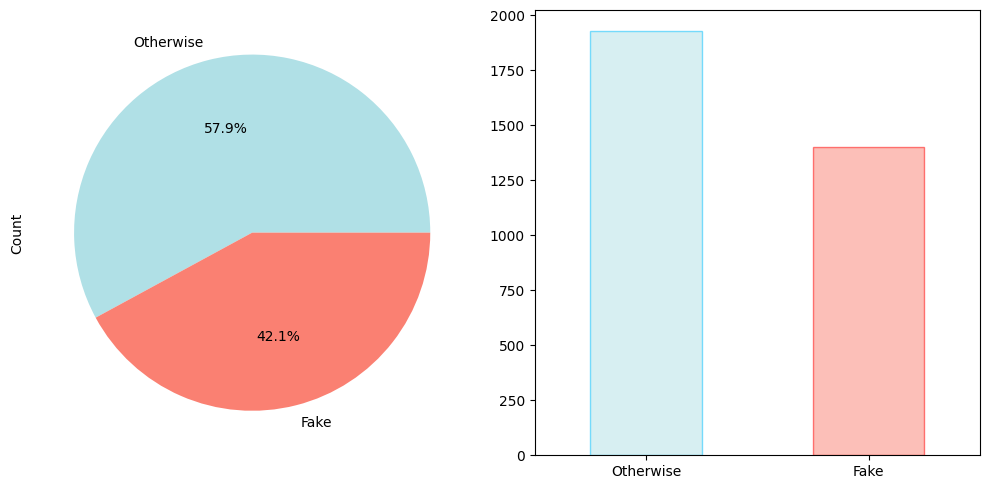

In [26]:
# Specify the path
data_path = r'C:\Users\yiwen\OneDrive\Desktop\fake_review_detection-main\data\product_level_data_with_img_feats.csv.gz'

# Load the data
df = pd.read_csv(data_path, compression='gzip')
df = df.drop('product_ID', axis=1)

# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Get the counts of 'fake=1' and 'fake=0'
fake_counts = df['fake'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create a pie chart in the first subplot
fake_counts.plot(kind='pie', autopct='%1.1f%%', colors=['powderblue', 'salmon'], labels=['Otherwise', 'Fake'], ax=axs[0])
axs[0].set_ylabel('Count')

# Create a histogram in the second subplot
fake_counts.plot(kind='bar', color=['powderblue', 'salmon'], alpha=0.5, edgecolor=['deepskyblue', 'red'], ax=axs[1])
axs[1].set_xticklabels(['Otherwise', 'Fake'], rotation=0)
axs[1].set_xlabel('')

# Display the plots
plt.tight_layout()
plt.show()

In [27]:
# Set a random seed for reproducibility
np.random.seed(340)

# Split the data into 80% training data and 20% unseen data
X = df.drop('fake', axis=1)
y = df['fake']
X_train, X_unseen, y_train, y_unseen = train_test_split(X, y, test_size=0.2, random_state=42)

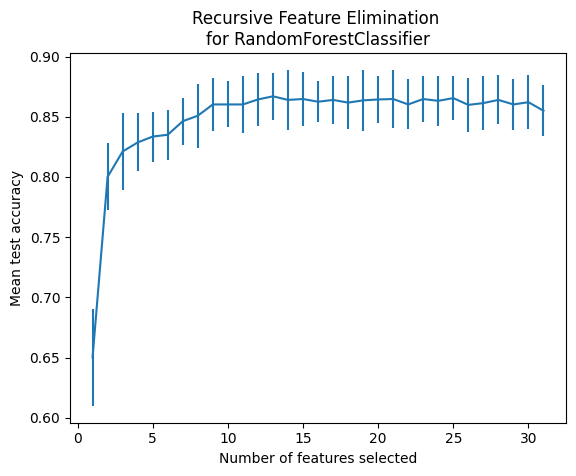

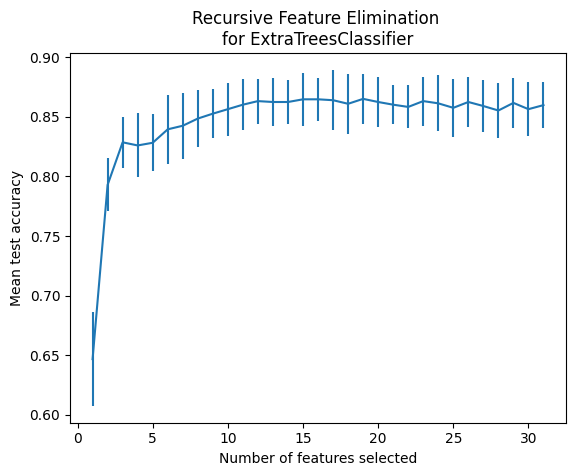

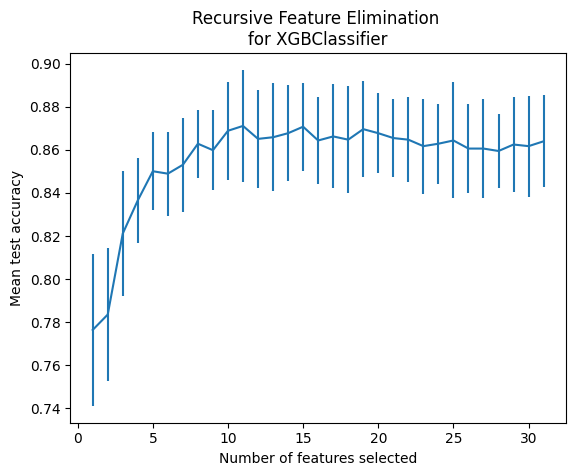

In [10]:
# Set a random seed for reproducibility
np.random.seed(340)

def feature_num_selection(X_train, y_train, model):
    # Create a Recursive Feature Elimination object with 10-flod cross-validation
    rfecv = RFECV(estimator=model, step=1, cv=KFold(10), scoring="accuracy", min_features_to_select=1, n_jobs=-1)
    
    # Fit the RFE object to the training data
    rfecv.fit(X_train, y_train)
    
    # Plot number of features vs. cross-validation scores
    n_scores = len(rfecv.cv_results_['mean_test_score'])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(range(1, n_scores + 1), rfecv.cv_results_['mean_test_score'], yerr=rfecv.cv_results_['std_test_score'])
    plt.title(f'Recursive Feature Elimination \nfor {model.__class__.__name__}')
    plt.show()

feature_num_selection(X_train, y_train, model=RandomForestClassifier())
feature_num_selection(X_train, y_train, model=ExtraTreesClassifier())
feature_num_selection(X_train, y_train, model=XGBClassifier())

Selected features for RandomForestClassifier: ['clustering_coef', 'eigenvector_cent', 'share_photo', 'w_degree', 'n_of_reviews', 'num_product_images', 'max_days_between_reviews', 'share_5star', 'pagerank', 'stdev_days_between_reviews', 'tfidf_review_body', 'avg_days_between_reviews', 'num_images', 'avg_review_rating', 'std_review_len']


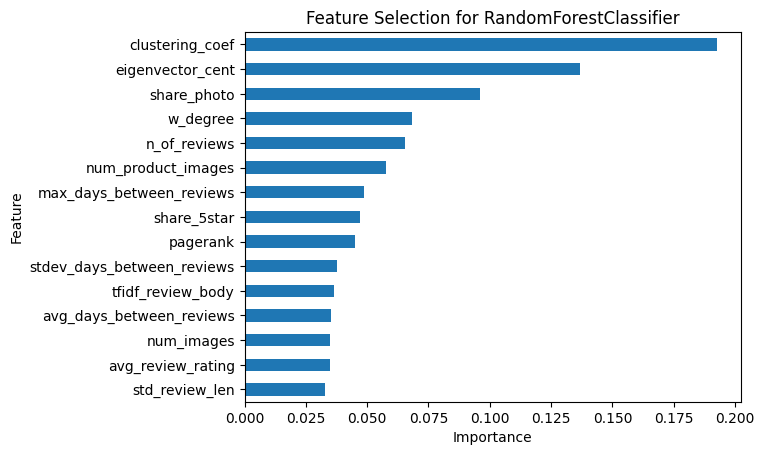

Selected features for ExtraTreesClassifier: ['eigenvector_cent', 'clustering_coef', 'num_product_images', 'share_photo', 'w_degree', 'n_of_reviews', 'pagerank', 'share_5star', 'max_days_between_reviews', 'tfidf_review_body', 'avg_review_rating', 'num_images', 'num_reviews', 'stdev_days_between_reviews', 'avg_days_between_reviews']


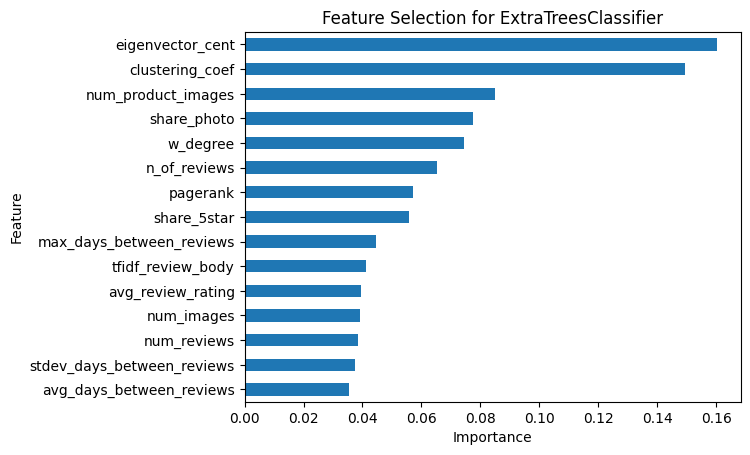

Selected features for XGBClassifier: ['clustering_coef', 'num_product_images', 'eigenvector_cent', 'n_of_reviews', 'share_photo', 'num_images', 'avg_days_between_reviews', 'share_5star', 'max_days_between_reviews', 'num_reviews', 'max_sim', 'tfidf_review_body', 'min_sim_product', 'std_sim_product', 'min_sim']


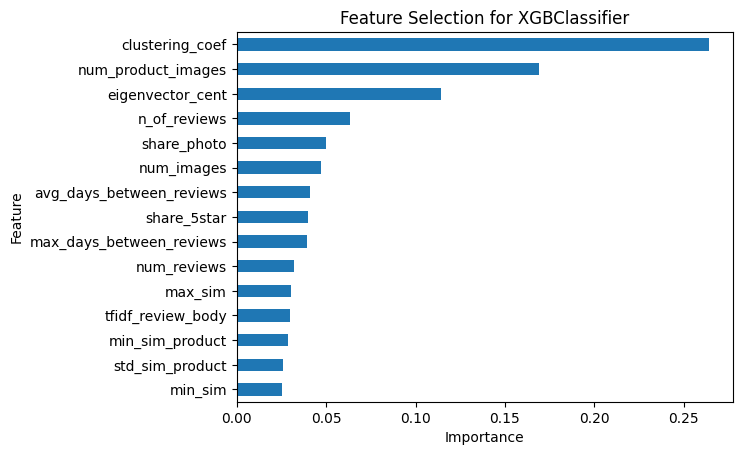

In [41]:
# Set a random seed for reproducibility
np.random.seed(340)

def feature_selection(X_train, y_train, model):
    
    # Create a Recursive Feature Elimination object with 10-flod cross-validation
    rfecv = RFECV(estimator=model, step=1, cv=KFold(10), scoring="accuracy", min_features_to_select=15, n_jobs=-1)
    
    # Fit the RFE object to the training data
    rfecv.fit(X_train, y_train)
    
    # Get the selected features
    selected_features = X_train.columns[rfecv.support_]
    
    # Get the feature importances from the fitted model
    importances = rfecv.estimator_.feature_importances_
    
    # Create a DataFrame with the features and their importances
    df_importances = pd.DataFrame({'feature': selected_features, 'importance': importances})
    
    # Sort the DataFrame by importance
    df_importances = df_importances.sort_values('importance', ascending=False)
    
    # Select the top 15 features
    top_features = df_importances['feature'].tolist()[:15]
    print(f"Selected features for {model.__class__.__name__}: {top_features}")
    
    # Plot the feature importances for the top 15 features
    df_importances[:15].plot(kind='barh', x='feature', y='importance', legend=False)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Selection for {model.__class__.__name__}')
    plt.gca().invert_yaxis()
    plt.show()
    
    return top_features

# Store the selected features for each model
selected_features_rf = feature_selection(X_train, y_train, model=RandomForestClassifier())
selected_features_et = feature_selection(X_train, y_train, model=ExtraTreesClassifier())
selected_features_xgb = feature_selection(X_train, y_train, model=XGBClassifier())

In [44]:
# Set a random seed for reproducibility
np.random.seed(340)

def random_search_tree(X_train, y_train, selected_features, model):
    
    # Define the random grid
    random_grid = {
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    # Create a RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=10, scoring='accuracy', n_jobs=-1)

    # Perform random search cross-validation
    random_search.fit(X_train[selected_features], y_train)

    # Get the best hyperparameters
    random_search_best = random_search.best_params_

    # Create a DataFrame from the best hyperparameters
    df_random_search_best = pd.DataFrame(list(random_search_best.items()), columns=['Hyperparameter', 'Value'])

    # Print the DataFrame with a title using tabulate
    print(f"Tuned Hyperparameters for {model.__class__.__name__}:\n{tabulate(df_random_search_best, headers='keys', tablefmt='psql', showindex=False)}")

    return random_search_best

random_search_best_rf = random_search_tree(X_train, y_train, selected_features_rf, RandomForestClassifier())
random_search_best_et = random_search_tree(X_train, y_train, selected_features_et, ExtraTreesClassifier())

Tuned Hyperparameters for RandomForestClassifier:
+-------------------+---------+
| Hyperparameter    | Value   |
|-------------------+---------|
| n_estimators      | 200     |
| min_samples_split | 2       |
| min_samples_leaf  | 1       |
| max_features      | log2    |
| max_depth         | 20      |
| bootstrap         | True    |
+-------------------+---------+
Tuned Hyperparameters for ExtraTreesClassifier:
+-------------------+---------+
| Hyperparameter    |   Value |
|-------------------+---------|
| n_estimators      |     800 |
| min_samples_split |       2 |
| min_samples_leaf  |       1 |
| max_features      |         |
| max_depth         |      20 |
| bootstrap         |    True |
+-------------------+---------+


In [47]:
# Set a random seed for reproducibility
np.random.seed(340)

def random_search_boost(X_train, y_train, selected_features):
    
    # Define the random grid
    random_grid = {
        'n_estimators': [100, 250, 500, 750],
        'max_depth': [3, 6, 10, 15],
        'subsample': np.arange(0.5, 1.0, 0.1),
        'colsample_bytree': np.arange(0.5, 1.0, 0.1),
        'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
        'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
    }

    # Create a RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), param_distributions=random_grid, n_iter=100, cv=10, scoring='accuracy', n_jobs=-1)

    # Perform random search cross-validation
    random_search.fit(X_train[selected_features], y_train)

    # Get the best hyperparameters
    random_search_best = random_search.best_params_

    # Create a DataFrame from the best hyperparameters
    df_random_search_best = pd.DataFrame(list(random_search_best.items()), columns=['Hyperparameter', 'Value'])

    # Print the DataFrame with a title using tabulate
    print(f"Tuned Hyperparameters for XGBoost:\n{tabulate(df_random_search_best, headers='keys', tablefmt='psql', showindex=False)}")

    return random_search_best

random_search_best_xgb = random_search_boost(X_train, y_train, selected_features_xgb)

Tuned Hyperparameters for XGBoost:
+-------------------+---------+
| Hyperparameter    |   Value |
|-------------------+---------|
| subsample         |    0.8  |
| n_estimators      |  250    |
| max_depth         |   15    |
| learning_rate     |    0.05 |
| colsample_bytree  |    0.8  |
| colsample_bylevel |    0.9  |
+-------------------+---------+


In [51]:
# Set a random seed for reproducibility
np.random.seed(340)

def model_selection(X_train, y_train, selected_features, model, model_name):
    
    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(model, X_train[selected_features], y_train, cv=10, scoring='accuracy')
    
    # Calculate the predictions to get other metrics
    y_pred = cross_val_predict(model, X_train[selected_features], y_train, cv=10)
    
    # Calculate the AUC
    auc = roc_auc_score(y_train, y_pred)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_train, y_pred)
    
    # Calculate the F1 score
    f1 = f1_score(y_train, y_pred)
    
    # Calculate the TPR and FPR
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Create a DataFrame with the results
    df_results = pd.DataFrame({
        'Model': [model_name],
        'AUC': [auc],
        'Accuracy': [accuracy],
        'F1 Score': [f1],
        'TPR': [tpr],
        'FPR': [fpr]
    })
    
    # Print the DataFrame with a title using tabulate
    print(f"Results for {model_name}:\n{tabulate(df_results, headers='keys', tablefmt='psql', showindex=False)}")

model_selection(X_train, y_train, selected_features_et, ExtraTreesClassifier(**random_search_best_et), 'ExtraTrees')
model_selection(X_train, y_train, selected_features_rf, RandomForestClassifier(**random_search_best_rf), 'RandomForest')
model_selection(X_train, y_train, selected_features_xgb, XGBClassifier(**random_search_best_xgb), 'XGBoost')

Results for ExtraTrees:
+------------+----------+------------+------------+----------+----------+
| Model      |      AUC |   Accuracy |   F1 Score |      TPR |      FPR |
|------------+----------+------------+------------+----------+----------|
| ExtraTrees | 0.864139 |    0.86847 |   0.842058 | 0.837522 | 0.109244 |
+------------+----------+------------+------------+----------+----------+
Results for RandomForest:
+--------------+----------+------------+------------+----------+----------+
| Model        |      AUC |   Accuracy |   F1 Score |      TPR |      FPR |
|--------------+----------+------------+------------+----------+----------|
| RandomForest | 0.864121 |   0.867719 |   0.842011 | 0.842011 | 0.113769 |
+--------------+----------+------------+------------+----------+----------+
Results for XGBoost:
+---------+----------+------------+------------+----------+-----------+
| Model   |      AUC |   Accuracy |   F1 Score |      TPR |       FPR |
|---------+----------+------------+

In [52]:
# Set a random seed for reproducibility
np.random.seed(340)

def model_testing(X_unseen, y_unseen, selected_features, model, model_name):
    
    # Fit the model on the training data
    model.fit(X_train[selected_features], y_train)
    
    # Predict the unseen data
    y_pred = model.predict(X_unseen[selected_features])
    
    # Calculate the AUC
    auc = roc_auc_score(y_unseen, y_pred)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_unseen, y_pred)
    
    # Calculate the F1 score
    f1 = f1_score(y_unseen, y_pred)
    
    # Calculate the TPR and FPR
    tn, fp, fn, tp = confusion_matrix(y_unseen, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Create a DataFrame with the results
    df_results = pd.DataFrame({
        'Model': [model_name],
        'AUC': [auc],
        'Accuracy': [accuracy],
        'F1 Score': [f1],
        'TPR': [tpr],
        'FPR': [fpr]
    })
    
    # Print the DataFrame with a title using tabulate
    print(f"Test Results for {model_name}:\n{tabulate(df_results, headers='keys', tablefmt='psql', showindex=False)}")

model_testing(X_unseen, y_unseen, selected_features_et, ExtraTreesClassifier(**random_search_best_et), 'ExtraTrees')
model_testing(X_unseen, y_unseen, selected_features_rf, RandomForestClassifier(**random_search_best_rf), 'RandomForest')
model_testing(X_unseen, y_unseen, selected_features_xgb, XGBClassifier(**random_search_best_xgb), 'XGBoost')

Test Results for ExtraTrees:
+------------+----------+------------+------------+----------+----------+
| Model      |      AUC |   Accuracy |   F1 Score |      TPR |      FPR |
|------------+----------+------------+------------+----------+----------|
| ExtraTrees | 0.871761 |   0.875375 |   0.853616 | 0.846154 | 0.102632 |
+------------+----------+------------+------------+----------+----------+
Test Results for RandomForest:
+--------------+----------+------------+------------+----------+----------+
| Model        |      AUC |   Accuracy |   F1 Score |      TPR |      FPR |
|--------------+----------+------------+------------+----------+----------|
| RandomForest | 0.865201 |   0.869369 |   0.846018 | 0.835664 | 0.105263 |
+--------------+----------+------------+------------+----------+----------+
Test Results for XGBoost:
+---------+----------+------------+------------+----------+----------+
| Model   |      AUC |   Accuracy |   F1 Score |      TPR |      FPR |
|---------+----------+